# Workshop: Using NLP for computer vision tasks

In this workshop we will explore the application of transformer based models by trying out zero-shot learning for computer vision using natural language supervision. What this means is we are going to learn how to classify images using a model which was trained on pairs of images and descriptions. This particular model is called CLIP and was released by OpenAI two years ago. 

## Part 1: Zero-shot classification

### Setup packages

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vflhqd2h
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-vflhqd2h
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=009a5a9b4b24a81befacd3aefe9c346dc58163e9cb6b73bbfa60ca4f3eeccdc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-43t08x64/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [ ]:
import os
import torch
import clip
import numpy as np
import pandas as pd
import plotly.express as px
from PIL import Image

### Load model and data

The model is pre-trained and thus ready to be used for inference straight away. This means we can just load it from the `clip` package. We specify the device in order to be able to utilise the GPU in Colab.

In [ ]:
# Specify wether to use cpu or gpu
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model and the preprocessing steps to apply to images
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 86.8MiB/s]


Upload an the `raspberries.jpeg` image and upload it to Colab.


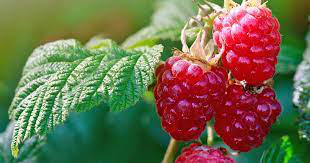

In [ ]:
# Load and check the image
image_raw = Image.open("raspberries.jpeg")
px.imshow(image_raw).show()

### Preprocess data

In order to use the model, we need to transform both our image and our potential labels. First, the image is just converted to a format where it suits the GPU/CPU and the text is tokenized. This means we clean our text from whitespace, split sentences into words, use numbers to represent those words and let the string be represented by a list of such tokens. For our purpose here this is mostly about getting the texts into a format that the model can handle, since we don't have sentences but only words. Finally the text and image are both encoded into the multidimensional feature space where the model operates.

In [ ]:
# Preprocess the image
image = preprocess(image_raw).unsqueeze(0).to(device)

In [ ]:
# Preprocess the text
text_alternatives = [
    "banana", 
    "apples", 
    "clementine", 
    "blueberry",
    "raspberry"
    ]
text = clip.tokenize(text_alternatives).to(device)

In [ ]:
# Get image and text features
image_features = model.encode_image(image)
text_features = model.encode_text(text)

In [ ]:
text_features.shape

torch.Size([5, 512])

How can we understand these "features"? There's quite many of them (512, in fact), and we don't have any description of them. This differs a bit from classic machine learning, where we have known features. It is, however, more similar to computer vision, where each pixel is a feature (in a sense) and thus hard to understand on it's own.

Let's try and look a little bit at what we've got here. 

In [ ]:
# Take a "look" at the embedding of the image (vector)
img_features_np = image_features.cpu().detach().numpy().reshape(image_features.shape[1])
print(img_features_np)
px.histogram(img_features_np)

[ 1.8567e-01  2.2046e-01 -6.4600e-01 -5.3564e-01 -5.4785e-01  1.4026e-01
  1.2939e-01  2.3407e-02  6.9971e-01  4.2749e-01 -1.9958e-01  3.1250e-01
 -3.3716e-01 -2.6001e-01  9.8694e-02 -1.5649e-01  1.1826e+00  2.3059e-01
  3.6353e-01 -3.7573e-01 -1.1260e+00  1.6937e-02 -5.0439e-01 -5.1172e-01
 -6.2805e-02 -2.2751e-02  7.1228e-02  2.9224e-01  2.0288e-01  4.8492e-02
  2.5620e-02  2.7417e-01  1.7810e-01 -3.9917e-01 -8.2336e-02  1.5076e-01
  2.6514e-01  5.5145e-02  1.3501e-01  1.5312e+00 -3.6743e-01 -3.2837e-01
  1.6809e-01 -4.6967e-02  2.3450e-01 -8.1641e-01  2.2913e-01  2.7075e-01
 -4.9072e-01  3.8745e-01  3.6963e-01  1.6638e-01 -3.0914e-02 -2.2742e-01
  3.1885e-01 -2.3572e-01 -2.2644e-01 -5.3418e-01 -1.8408e-01  1.9604e-01
  4.6167e-01  2.6440e-01  1.1401e-01 -2.7725e-02 -6.3110e-02  9.9548e-02
 -4.5288e-01  3.2886e-01 -2.6025e-01 -5.4230e-02  1.6431e-01  9.2102e-02
 -2.0837e-01 -1.9592e-01 -1.4626e-02 -1.5771e-01 -4.2432e-01 -4.7510e-01
  2.6855e-01 -6.1914e-01 -2.4927e-01  1.5967e-01 -4

In [ ]:
# Take a "look" at the embedding
text_features_np = text_features.cpu().detach().numpy()
for i, text_features in enumerate(text_features_np):
  px.histogram(text_features, title=f"Feature vector for text: {text_alternatives[i]}").show()
  print(text_features)

[ 1.9421e-01  1.0876e-01  1.7505e-01  4.4116e-01 -4.9463e-01 -2.1777e-01
 -2.9517e-01 -1.2018e-01 -3.8501e-01  2.2791e-01 -5.0488e-01 -6.3904e-02
  2.1753e-01 -6.9458e-02  6.8994e-01 -1.2048e-01  3.2349e-01  1.8689e-01
 -4.0283e-03  8.2153e-02  2.1753e-01  5.9766e-01 -3.3032e-01  5.7129e-01
 -1.0223e-01  2.6416e-01 -9.4604e-02 -8.4229e-02 -1.5137e-01  4.7607e-01
 -1.4624e-01 -2.0825e-01 -2.8662e-01  5.1807e-01 -7.3547e-02 -3.8428e-01
 -1.0028e-01 -1.3000e-01 -1.9531e-01  9.3323e-02  2.2278e-01 -1.0797e-01
  3.8770e-01  1.0675e-01  2.3669e-01  2.9810e-01  4.6338e-01  1.2781e-01
  8.2153e-02 -2.5925e-02 -1.3237e-03 -3.9062e-01  5.9631e-02 -4.6310e-03
 -9.0210e-02  8.0078e-02  1.7358e-01  7.1289e-02 -2.8107e-02  3.3203e-01
  1.5747e-01 -8.1604e-02  1.2073e-01 -5.4688e-01  2.1729e-02  2.6794e-02
 -4.1553e-01  5.3711e-01 -1.6541e-01 -1.5125e-01  2.8882e-01 -6.4331e-02
 -1.4258e-01  2.5195e-01  3.0884e-01 -1.4328e-02  5.5923e-03 -7.7087e-02
 -1.3843e-01 -2.1851e-01  1.1688e-01  3.1464e-02  1

[-1.1060e-01 -6.9580e-03  9.6680e-02  1.8237e-01 -1.2445e-01 -2.3413e-01
 -4.9854e-01 -1.0244e+00 -1.2396e-01 -5.5962e-03  3.1616e-02  2.1143e-01
 -6.9727e-01  9.9365e-02  2.5879e-01  6.5979e-02  1.2091e-01  5.2856e-02
 -3.1641e-01  6.3232e-02  3.5913e-01 -3.1104e-01  5.4248e-01  1.6333e-01
 -2.0020e-01 -3.2806e-03 -5.3406e-03  1.4709e-01 -2.1021e-01  4.0845e-01
 -1.9482e-01 -5.3955e-02 -3.6670e-01  7.5781e-01 -2.1094e-01  2.3804e-01
 -5.4932e-04  1.8823e-01 -1.4209e-01 -1.7834e-01 -4.9774e-02 -8.8989e-02
  3.9233e-01 -5.1416e-01  4.8218e-02  1.6479e-01 -1.1548e-01  8.9600e-02
  2.1301e-01  4.1772e-01  2.2266e-01 -4.8413e-01  2.6099e-01 -1.3953e-01
  8.8379e-02 -4.7943e-02 -2.4902e-01 -1.7090e-02 -2.0117e-01  6.5967e-01
  1.5869e-01  1.0596e-01  3.4961e-01 -4.8553e-02 -9.2468e-02 -1.6174e-01
 -4.3726e-01  1.2042e-01 -1.8848e-01  2.2247e-02  3.4546e-01 -3.6865e-01
  1.8213e-01  3.0396e-01 -4.6289e-01  1.3428e-01 -3.4155e-01 -7.1228e-02
 -1.5625e-01 -1.8286e-01 -8.6853e-02  4.6045e-01  2

[ 1.3513e-01  1.4771e-01  2.2049e-02  2.8491e-01  1.7676e-01 -2.0081e-01
 -4.0649e-01 -1.1084e+00 -4.8901e-01  6.2744e-02  6.9336e-02  2.3291e-01
 -4.1162e-01 -1.1890e-01 -4.2725e-03  3.2776e-02  1.4526e-01  1.9092e-01
 -7.1594e-02 -2.6611e-01  5.7568e-01 -3.3130e-01 -1.5491e-01  2.4622e-01
 -8.9844e-02  2.4683e-01  2.8491e-01  9.9609e-02 -6.1035e-05  1.2219e-01
  1.2292e-01  1.7114e-01 -2.2571e-01 -1.8884e-01  3.1079e-01  4.3701e-01
  9.4971e-02 -6.1340e-02  1.5747e-01  1.0901e-01 -1.8469e-01 -3.6279e-01
 -2.2888e-01 -2.0093e-01  1.5710e-01  1.2195e-01 -1.3440e-01  4.6729e-01
 -1.3000e-01  2.1179e-01 -2.7051e-01 -4.9438e-01  6.9031e-02 -7.8674e-02
  4.4739e-02 -3.0786e-01  3.1299e-01 -2.3401e-01 -1.1890e-01  4.0283e-01
  1.6589e-01 -3.0054e-01  2.1240e-01  4.6875e-02 -3.8971e-02 -3.0298e-01
  7.5806e-02 -4.7211e-02 -4.2896e-01 -2.3816e-01 -3.1543e-01 -1.5234e-01
  3.3936e-01  2.5024e-01 -4.1382e-02 -1.2769e-01 -2.9984e-02  8.7402e-02
 -3.3447e-02  1.8921e-01  1.8970e-01 -2.1021e-01 -1

[ 1.6589e-01 -3.0737e-01 -1.3229e-02  1.5417e-01  2.4512e-01 -3.9307e-01
 -3.5229e-01 -1.0811e+00  1.6748e-01  4.6417e-02 -6.1279e-02  1.9604e-01
 -2.0227e-01  8.7524e-02 -1.8298e-01  2.0801e-01  4.6069e-01  9.1492e-02
 -6.6162e-02  2.1655e-01  2.6147e-01  7.4646e-02 -8.6243e-02  2.4561e-01
 -4.9316e-02 -1.8997e-02  2.3376e-02 -1.2280e-01 -1.8811e-01  5.1514e-01
 -2.7512e-02  1.3013e-01 -3.0151e-01 -1.3232e-01  6.0547e-01 -5.2261e-03
  3.3716e-01  1.6479e-01  5.7281e-02  1.1969e-01  1.7554e-01  1.2347e-01
  2.0679e-01 -1.4246e-01  3.3447e-01  1.1969e-01  9.6802e-02 -2.5482e-02
  9.1400e-03 -1.5747e-01  2.7295e-01 -2.5391e-01  2.7759e-01 -2.2156e-01
  1.7303e-02 -1.3721e-01 -2.0007e-01  4.1321e-02 -3.7524e-01  3.0103e-01
  2.0837e-01 -5.1904e-01  2.6660e-01 -3.7598e-01 -8.6731e-02 -2.1680e-01
 -5.9662e-02  6.8726e-02  1.1497e-02 -3.6865e-02  3.3496e-01 -1.3135e-01
 -2.2064e-02  1.1438e-01 -4.2603e-01 -1.3962e-03  2.5986e-02  2.2107e-01
 -3.1799e-02 -2.6709e-01 -2.8735e-01 -1.0864e-01 -8

[-2.7124e-01 -4.4873e-01  5.0537e-02 -3.0762e-01 -2.3511e-01  1.1951e-01
 -1.0449e-01 -1.1602e+00  2.3572e-01  1.2140e-01 -4.0710e-02 -2.8735e-01
 -5.3271e-01 -1.1620e-02  9.2468e-02  2.2339e-01  3.2886e-01  2.3169e-01
 -4.4464e-02 -2.2522e-02  3.6743e-01  3.5938e-01  2.1997e-01  5.0391e-01
 -2.1484e-01  2.0410e-01  9.5978e-03 -9.3811e-02 -2.2693e-01  2.2888e-01
 -1.9031e-01  2.1460e-01 -2.9883e-01  1.6223e-01  2.7603e-02 -1.6510e-02
 -2.6636e-01  1.0907e-01 -8.3557e-02  2.7466e-03 -2.2620e-01 -9.2468e-03
  2.8174e-01 -1.3855e-01  5.5756e-02  5.2612e-02  2.6758e-01 -5.9998e-02
 -2.6807e-01 -3.4943e-02  5.7159e-02 -3.8013e-01  3.6450e-01 -1.8579e-01
  2.7222e-01  1.7859e-01  1.4328e-02 -2.1643e-01 -3.8403e-01  4.7192e-01
  3.6963e-01 -1.7383e-01  4.4824e-01 -1.7725e-01 -1.6748e-01 -2.4365e-01
 -2.2937e-01 -2.6688e-02 -3.3325e-01  6.1523e-02  3.4570e-01 -1.6016e-01
  1.2439e-01  3.0563e-02 -3.9429e-01  1.6943e-01 -9.3079e-02 -1.2396e-01
  1.2372e-01 -2.0593e-01 -2.4292e-01  5.4541e-01  6

What we are dealing with here is a 512-dimensional vector. In this domain this is called an embedding. It is a representation of the images and words in a 512-dimensional space. How can we understand this space and these feature embeddings? What do they represent?

Let's dig into an arbitrary example in a low-dimensional space to understand this better.

Below you see three 2-dimensional vectors. They live in an xy-plane, which is the graph I drew. `x` and `y` both represents some information, and the values in each vector tells us something about the points. For example, we can see that the red and blue dot are closer to each other while the green dot is further away. This is key in many language models - words that carry similar meaning should be close to each other in the feature space. 

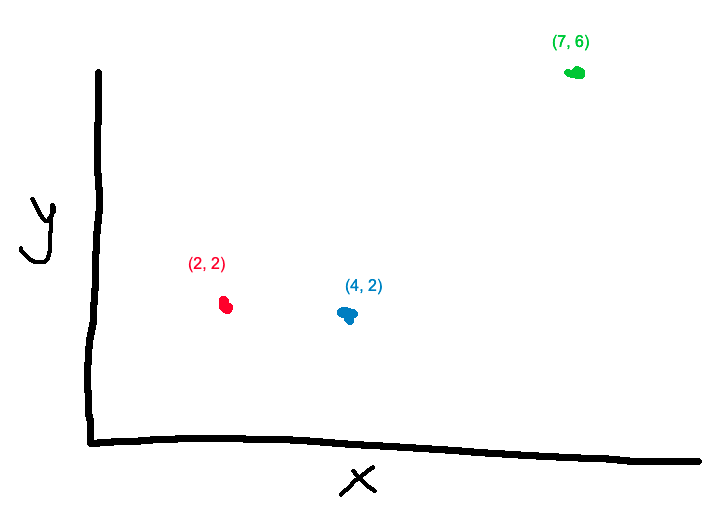

In 2 dimensions it is easier to visualize. As soon as we move beyond 3 dimensions, we essentially loose the ability to visualise the vector as a point in some space. We do not know what each and every one of the 512 axes in our case represent. We only know that it was possible to summarize a lot of meaning in that 512-dimensional space, and thus it makes the model successful (which we are about to see in practice!).

### Prediction

In [ ]:
# Use probabilities for text related to image
logits_per_image, logits_per_text = model(image, text)
probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy()
print("Text alternatives:", text_alternatives)
print("Label probabilities:", np.round(probs, 3))

Text alternatives: ['banana', 'apples', 'clementine', 'blueberry', 'raspberry']
Label probabilities: [[0.    0.    0.    0.    0.999]]



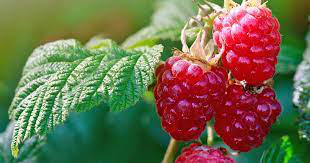

In [ ]:
# Use probabilities for classification
classification = text_alternatives[np.argmax(probs)]
px.imshow(image_raw, title=f"Classification: {classification}")

Let's all find a new image, probe it with some new text alternatives, and report back!

## Part 2: Gender bias experiment

### Load data

Upload the doctors.zip file, then run the command below to unzip.

In [ ]:
!unzip doctors.zip

Archive:  doctors.zip
   creating: doctors/
  inflating: doctors/.DS_Store       
  inflating: __MACOSX/doctors/._.DS_Store  
   creating: doctors/male/
   creating: doctors/female/
  inflating: doctors/male/male-doctor-10.jpeg  
  inflating: __MACOSX/doctors/male/._male-doctor-10.jpeg  
  inflating: doctors/male/male-doctor-7.jpeg  
  inflating: __MACOSX/doctors/male/._male-doctor-7.jpeg  
  inflating: doctors/male/male-doctor-4.webp  
  inflating: __MACOSX/doctors/male/._male-doctor-4.webp  
  inflating: doctors/male/male-doctor-2.jpeg  
  inflating: __MACOSX/doctors/male/._male-doctor-2.jpeg  
  inflating: doctors/male/male-doctor-1.png  
  inflating: __MACOSX/doctors/male/._male-doctor-1.png  
  inflating: doctors/male/male-doctor-6.webp  
  inflating: __MACOSX/doctors/male/._male-doctor-6.webp  
  inflating: doctors/male/male-doctor-3.jpeg  
  inflating: __MACOSX/doctors/male/._male-doctor-3.jpeg  
  inflating: doctors/male/male-doctor-8.jpeg  
  inflating: __MACOSX/doctors/male/.

### Use the model for prediction

We're now going to evaluate a few more images, so let's make a function which takes an image and some text alternatives and makes a classification for us. 

In [ ]:
def predict(image_raw, text_alternatives):
  # Preprocess
  image = preprocess(image_raw).unsqueeze(0).to(device)
  text = clip.tokenize(text_alternatives).to(device)

  # Set model to inference mode
  with torch.no_grad():
    # Get image and text features
    model.encode_image(image)
    model.encode_text(text)

    # Get probabilities
    logits_per_image, _ = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().reshape(len(text_alternatives))

    # Make prediction
    classification = text_alternatives[np.argmax(probs)]

  return classification, probs

In the folder `doctors`, we have two subfolders. One contains images of male doctors and one contains images of female doctors. Look through some of them before you proceed. Our goal is to classify their occupation.

To do this, we are going to iterate over these subfolders, load the image and make a prediction.

In [ ]:
# Specify occupations
text_alternatives = [
    "basket ball player",
    "alpine skier",
    "doctor",
    "nurse"
]
# Somewhere to store our results
result = {}

# Iterate over each subfolder
for group in ["female", "male"]:
  directory = os.path.join("doctors", group)
  probabilities = dict(zip(text_alternatives, [[], [], [], []]))
  classifications = []

  # Iterate over the images in the subfolder
  for filename in os.listdir(directory):

    # Make sure it's not a hidden file
    if not filename.startswith('.'):

      # Load image
      image_raw = Image.open(os.path.join(directory, filename))

      # Get predictions
      classification, probs = predict(image_raw, text_alternatives)

      # Save result
      classifications.append(classification)
      for i, p in enumerate(probs):
        probabilities[text_alternatives[i]].append(p)

  result[group] = {"class": classifications, "p": probabilities}

### Evaluate

We can evaluate the bias in this model in at least two ways: by checking it's accuracy, and by inspecting the probabilities for the other text_alternatives.

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(group):
  number_of_examples = len(result[group]["class"])
  number_of_correct = sum([c == "doctor" for c in result[group]["class"]])
  accuracy = number_of_correct/number_of_examples

  return number_of_correct, number_of_examples, accuracy

In [ ]:
for group in ["male", "female"]:
  number_of_correct, number_of_examples, accuracy = calculate_accuracy(group)
  print(f"Accuracy for the {group} doctors: {number_of_correct}/{number_of_examples} = {accuracy*100}% correctly classified")

Accuracy for the male doctors: 9/10 = 90.0% correctly classified
Accuracy for the female doctors: 5/10 = 50.0% correctly classified


We can also inspect the distribution of probabilities for the carious occupations for the men and the women.

In [ ]:
# Transform probabilities to a pandas df
df_list = []
i = 0
for group in ["female", "male"]:
  for occupation, probs in result[group]["p"].items():
    df = pd.DataFrame()
    df["p"] = probs
    df["class"] = occupation
    df["group"] = group
    df_list.append(df)
probs_df = pd.concat(df_list)

# Plot to compare
fig = px.box(probs_df, x="p", y="group", color="group", facet_row="class")
for a in fig.layout.annotations:
    a.text = a.text.split("=")[1]
fig.show()

As you can see in the graph above, the male doctors usually got a pretty high probability for the occuption "doctor". The women had lower probability for this class, and instead higher for "nurse". 

Now before we finish, try and think of what you as a developer can do to prevent unintended harm caused by a classification model like this. How would you collect your data? What happens if you change the classification alternatives? How can you inform stakeholders about the risk to ensure a serious discussion?